### Introduction

In this notebook, the focus will be on applying clustering techniques to the preprocessed dataset. After completing the necessary data transformations, the data is now ready for unsupervised learning.

The key steps in this notebook include:

- **Model selection**, with a focus on the K-Means algorithm for clustering.
- **Model training**, where the optimal number of clusters will be determined.
- **Evaluation and visualization of clusters**, to assess the patterns and relationships identified in the data.

These steps are crucial for uncovering hidden structures within the dataset and gaining deeper insights.


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler


%run ../customer_personality_analysis/utils/params_optimizer.py

path = '../customer_personality_analysis/data/preprocessed.csv'
df = pd.read_csv(path).drop(columns=['Unnamed: 0'])
df.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


# Applying PCA and Kmeans:
## Selecting the Best Combination of n_components and n_clusters

## Objective
The goal of this analysis is to identify the optimal combination of principal components (n_components) and the number of clusters (n_clusters) that maximize the quality of clustering, by evaluating key metrics.

## Technique
To achieve this, we will employ a technique that scales and combines relevant metrics, including:

1. **Explained Variance**: This measures how much information is retained by the principal components. Both the explained variance by each component and the cumulative explained variance will be used.
   
2. **Silhouette Coefficient**: This value reflects the quality of the clusters, measuring how similar points within the same cluster are compared to other clusters.

3. **Inertia**: Represents the internal dispersion within clusters. Lower inertia generally indicates more compact clusters.

### Procedure
1. **Scaling the Metrics**: 
   We will apply `MinMaxScaler` to normalize the different metrics, as they are on different scales. This way, all metrics will have values between 0 and 1.

2. **Score Calculation**:
   - **Explained Variance Score**: We will combine the explained variance and the cumulative variance into a single score.
   - **Silhouette and Clusters Score**: The silhouette score will be combined with the number of clusters, favoring configurations with fewer clusters.
   
3. **Total Score**: 
   A total score will be computed by averaging the two previous scores to balance the importance of retained information (explained variance) and cluster quality (silhouette).

4. **Sorting Results**: 
   The results will be sorted based on the total score to identify the best combinations of `n_components` and `n_clusters`.

### Benefits of the Technique
This approach systematically evaluates different parameter combinations, considering multiple relevant metrics for both dimensionality reduction (PCA) and clustering quality (KMeans). By balancing explained variance and silhouette score, we ensure a trade-off between retaining information and achieving high-quality clustering.

## Conclusion
Through this technique, we will identify the configuration that provides the best clustering quality while retaining as much original information as possible. This will enable a more efficient and meaningful analysis of the data.



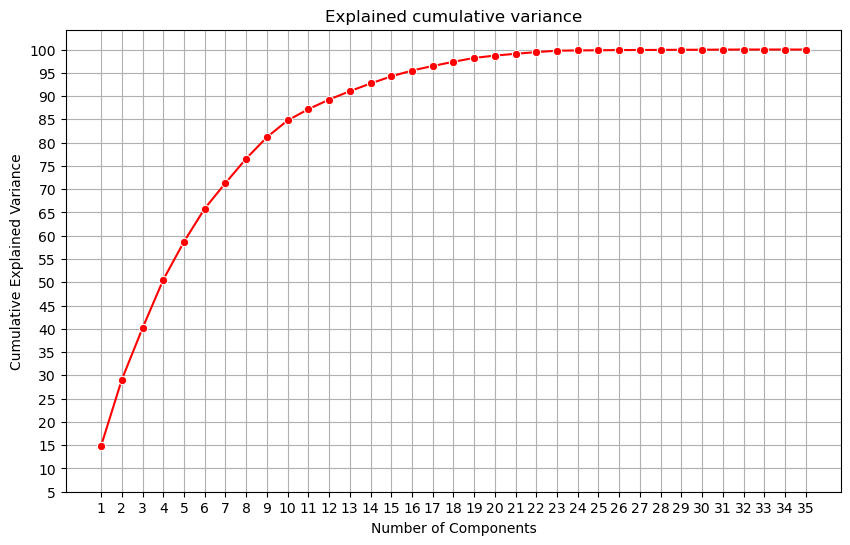

In [32]:
plt.figure(figsize=(10,6))
plt.title('Explained cumulative variance')
df.params_optimizer.plot_explained_variance()

In [33]:
n_components = 10
pca = PCA(n_components=n_components, random_state=42)
data_pca = pca.fit_transform(df)

In [34]:
feature_contributions = pd.DataFrame(
    pca.components_[:n_components],
    columns=df.columns,
    index=[f"PC{i+1}" for i in range(n_components)]
)
feature_contributions.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
PC1,-0.001186,0.000789,-0.001550,-0.007734,0.004139,-0.001084,0.001749,0.000872,-0.000447,0.000812,...,-0.095985,-0.019178,0.830076,-0.250962,-0.463951,0.005639,-0.113056,0.066307,0.048902,-0.007793
PC2,0.001735,-0.000797,0.003482,0.002638,0.005363,0.000853,-0.000848,-0.000418,-0.000273,-0.000502,...,-0.009739,-0.006062,0.116387,-0.060651,-0.039935,-0.062227,0.819172,-0.252108,-0.487554,-0.017284
PC3,0.000226,-0.000022,-0.011318,0.005025,-0.010592,-0.000016,0.000261,0.001373,-0.000014,0.000360,...,-0.000242,0.014414,-0.016829,0.008426,-0.005768,0.031298,-0.009995,0.103694,-0.130778,0.005781
PC4,-0.000059,-0.000569,-0.000231,-0.004045,0.000453,0.000177,0.002669,0.001097,-0.000043,0.001747,...,-0.037888,0.001232,0.009910,-0.078982,0.105727,0.052208,-0.142838,0.693878,-0.619042,0.015794
PC5,0.000382,-0.001252,0.004694,-0.010433,-0.002433,-0.001772,0.000733,0.000320,0.000522,-0.000102,...,0.090457,0.022764,-0.156251,0.677157,-0.634127,-0.031889,0.007640,0.160678,-0.115502,-0.020927


In [35]:
top_features = feature_contributions.abs().sum(axis=0).sort_values(ascending=False).head(10).index
X_selected = df[top_features]
X_selected.head()

,YearJoining,QuarterJoining,Marital_Status_Single,Marital_Status_Together,Education_Master,Response,Education_PhD,Marital_Status_Married,Marital_Status_Divorced,Education_Graduation
0,0,0,1,0,0,1,0,0,0,1
1,1,0,1,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,1
3,1,0,0,1,0,0,0,0,0,1
4,1,0,0,0,0,0,1,1,0,0


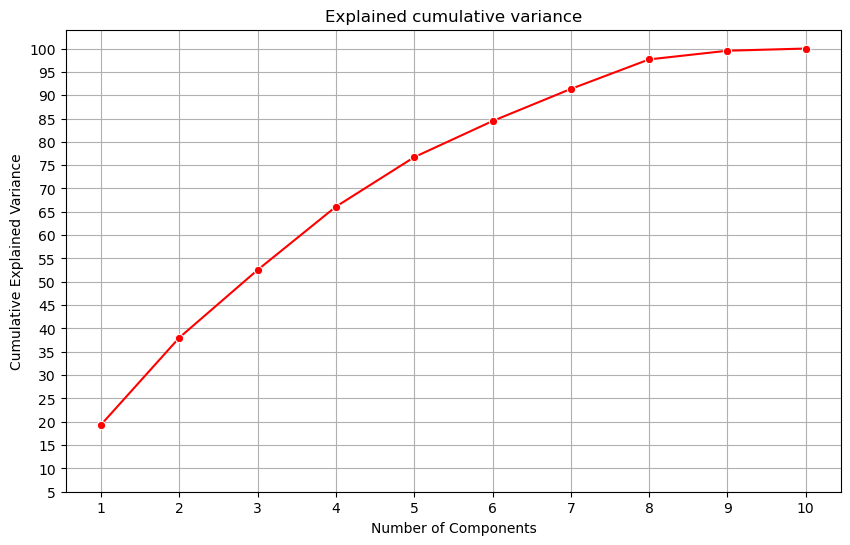

In [36]:
plt.figure(figsize=(10,6))
plt.title('Explained cumulative variance')
df[X_selected.columns].params_optimizer.plot_explained_variance()

In [37]:
kmeans_study = df.params_optimizer.pca_kmeans_study(
    pca_n_components_range=11,
    n_clusters_range=21
)

In [48]:
kmeans_study[kmeans_study['n_components'] >= 7].sort_values('silhouette_score', ascending = False).head(40)

,n_components,n_clusters,explained_variance,cumulative_explained_variance_ratio,silhouette_score,inertia,scaled_n_components,scaled_n_clusters,scaled_explained_variance,scaled_cumulative_explained_variance_ratio,scaled_silhouette_score,scaled_inertia,exp_var_Score,silhouette_n_clust_score,total_score
113,7,20,0.054650,0.713093,0.483133,755.111751,0.625,1.000000,0.175122,0.758138,0.460548,0.210413,0.466630,0.230274,0.348452
151,9,20,0.045988,0.811680,0.475747,1011.104911,0.875,1.000000,0.093596,0.935248,0.449173,0.281959,0.514422,0.224586,0.369504
112,7,19,0.054650,0.713093,0.469564,794.964878,0.625,0.944444,0.175122,0.758138,0.439651,0.221551,0.466630,0.247603,0.357117
132,8,20,0.052600,0.765692,0.467930,873.090760,0.750,1.000000,0.155827,0.852632,0.437134,0.243386,0.504229,0.218567,0.361398
150,9,19,0.045988,0.811680,0.463027,1045.257885,0.875,0.944444,0.093596,0.935248,0.429583,0.291504,0.514422,0.242569,0.378495
131,8,19,0.052600,0.765692,0.459139,906.600987,0.750,0.944444,0.155827,0.852632,0.423595,0.252752,0.504229,0.239575,0.371902
111,7,18,0.054650,0.713093,0.451570,832.179553,0.625,0.888889,0.175122,0.758138,0.411937,0.231952,0.466630,0.261524,0.364077
149,9,18,0.045988,0.811680,0.451315,1097.500395,0.875,0.888889,0.093596,0.935248,0.411544,0.306105,0.514422,0.261328,0.387875
130,8,18,0.052600,0.765692,0.449840,949.534550,0.750,0.888889,0.155827,0.852632,0.409274,0.264751,0.504229,0.260192,0.382211
129,8,17,0.052600,0.765692,0.441922,988.591815,0.750,0.833333,0.155827,0.852632,0.397078,0.275667,0.504229,0.281873,0.393051


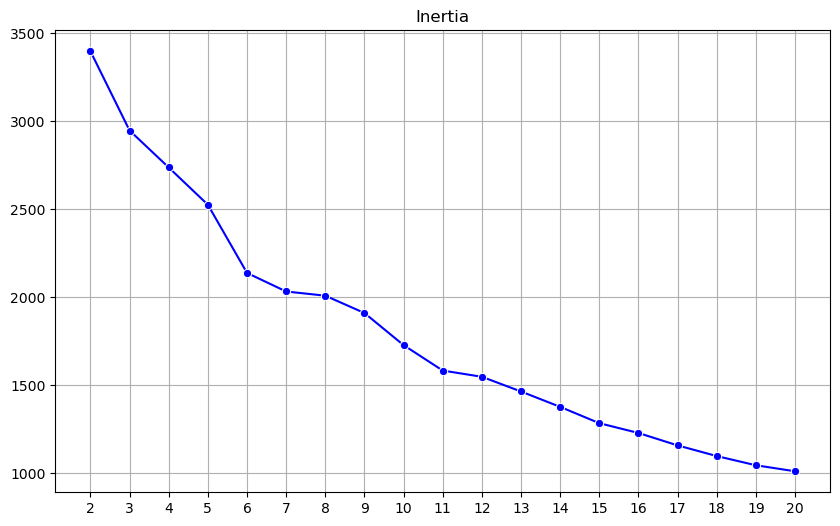

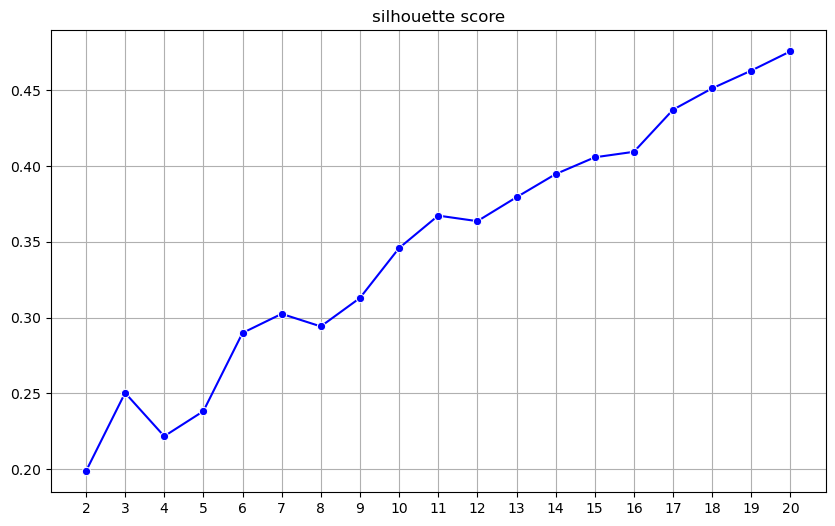

In [45]:
n_components = 9
pca = PCA(n_components=n_components, random_state=42)
data_pca = pca.fit_transform(df)
explained_variance = pca.explained_variance_ratio_.cumsum()*100

inertia = []
silhouette_avg = []

clusters_range = range(2,21)
for k in clusters_range:
    kmeans = KMeans(n_clusters=k,random_state=42) # Initializing the KMeans model
    cluster_labels = kmeans.fit_predict(data_pca)  # Making predictions on PCA data
    inertia.append(kmeans.inertia_)  # Adding the inertia data to the 'inertia' list
    silhouette_avg.append(silhouette_score(data_pca, cluster_labels)) # Adding the silhouette scores to the 'silhouette_avg' list

# Inertia chart
plt.figure(figsize=(10,6))
plt.title('Inertia')
sns.lineplot(
    x=clusters_range,
    y=inertia,
    marker="o",
    color='b'
)
plt.xticks(clusters_range)
plt.grid()
plt.show()

# Silhouette Score chart
plt.figure(figsize=(10,6))
plt.title('silhouette score')
sns.lineplot(
    x=clusters_range,
    y=silhouette_avg,
    marker="o",
    color='b'
)
plt.xticks(clusters_range)
plt.grid()
plt.show()


## Visualizing the results:

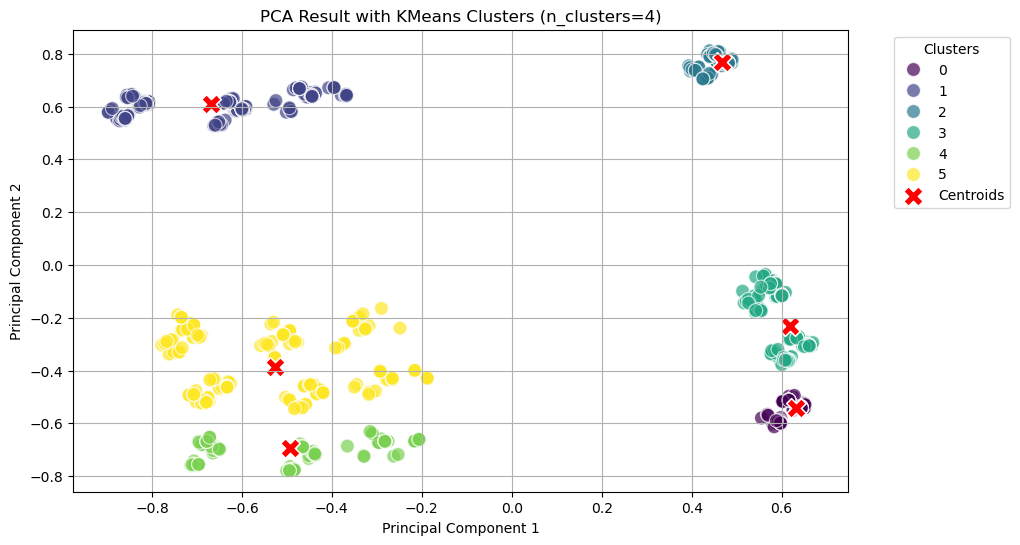

In [40]:
kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(data_pca)

# Obtener los centroides
centroids = kmeans.cluster_centers_

# Graficar los resultados
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=cluster_labels, palette='viridis', s=100, alpha=0.7)

# Graficar los centroides
sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], color='red', s=200, marker='X', label='Centroids')

plt.title(f'PCA Result with KMeans Clusters (n_clusters={4})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Agregar una leyenda
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [41]:
path = '../customer_personality_analysis/data/cleaned_data.csv'
original_dataset = pd.read_csv(path).drop(columns=['Unnamed: 0'])
original_dataset['Kmeans_labels'] = cluster_labels
original_dataset.head(10)

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,YearJoining,QuarterJoining,Kmeans_labels
0,1957,Graduation,Single,58138.0,0,0,58,635,88,546,...,0,0,0,0,0,0,1,2012,3,3
1,1954,Graduation,Single,46344.0,1,1,38,11,1,6,...,0,0,0,0,0,0,0,2014,1,3
2,1965,Graduation,Together,71613.0,0,0,26,426,49,127,...,0,0,0,0,0,0,0,2013,3,0
3,1984,Graduation,Together,26646.0,1,0,26,11,4,20,...,0,0,0,0,0,0,0,2014,1,0
4,1981,PhD,Married,58293.0,1,0,94,173,43,118,...,0,0,0,0,0,0,0,2014,1,1
5,1967,Master,Together,62513.0,0,1,16,520,42,98,...,0,0,0,0,0,0,0,2013,3,4
6,1971,Graduation,Divorced,55635.0,0,1,34,235,65,164,...,0,0,0,0,0,0,0,2012,4,3
7,1985,PhD,Married,33454.0,1,0,32,76,10,56,...,0,0,0,0,0,0,0,2013,2,1
8,1974,PhD,Together,30351.0,1,0,19,14,0,24,...,0,0,0,0,0,0,1,2013,2,4
9,1983,Graduation,Married,32382.4,1,0,11,5,5,6,...,0,0,0,0,0,0,0,2013,4,2


## Saving the clustered dataset into a csv file

In [42]:
original_dataset.to_csv('../customer_personality_analysis/data/clustered.csv', index=False)

# Conclusions

In this notebook, a modeling process was carried out using clustering techniques with KMeans. The following steps were followed, and the following results were obtained:

1. **Data Preprocessing**: Feature normalization was performed using PCA, which allowed for dimensionality reduction of the dataset and facilitated pattern identification.

2. **Determining the Number of Clusters**: Different combinations of `n_components` and `n_clusters` were evaluated, using metrics such as explained variance and silhouette coefficient to identify the best configuration.

3. **Clustering**: The KMeans algorithm was applied with the optimal number of clusters determined earlier. Subsequently, the array of cluster labels was added to the original DataFrame, allowing for better interpretation of the results and the assignment of each record to its respective group.

4. **Final Results**: Four distinct clusters were obtained, each with specific characteristics. These clusters can be used to segment the database and facilitate decision-making based on the identified groups.
